In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from scipy.spatial import distance
import torch
import numpy as np
import time

In [2]:
train_dir = "../inputs/JSON/train/"
valid_dir = "../inputs/JSON/valid/"
ccw_dir = "../inputs/JSON/counterclockwise-tracks/"
track_file_dir = 'C:/Users/Jumana/Desktop/FS-AI\REPO/fs-system/planning/deep_learning/inputs/JSON/ccw_with_path'

In [3]:
def countNumCones(dir):
    blue_cone_count_total = 0
    yellow_cone_count_total = 0

    for tracks in os.listdir(dir):
        if tracks.endswith(".json"):
            tracks_path = os.path.join(dir, tracks)
            with open(tracks_path, 'r') as file:
                json_data = json.load(file)

            # Extract x and y coordinates for blue and yellow cones
            x_blue = [json_data["x"][i] for i, color in enumerate(json_data["color"]) if color == "blue"]
            y_blue = [json_data["y"][i] for i, color in enumerate(json_data["color"]) if color == "blue"]
            x_yellow = [json_data["x"][i] for i, color in enumerate(json_data["color"]) if color == "yellow"]
            y_yellow = [json_data["y"][i] for i, color in enumerate(json_data["color"]) if color == "yellow"]

            # Count blue and yellow cones in the current file
            blue_cone_count_total += len(x_blue)
            yellow_cone_count_total += len(x_yellow)

        # Print total counts
        print(f"Total number of blue cones in {tracks}: {blue_cone_count_total}")
        print(f"Total number of yellow cones in {tracks}: {yellow_cone_count_total}")
        print("--------------------------------------------------------")

countNumCones(train_dir)
countNumCones(valid_dir)



Total number of blue cones in track (1).json: 236
Total number of yellow cones in track (1).json: 232
--------------------------------------------------------
Total number of blue cones in track (10).json: 461
Total number of yellow cones in track (10).json: 449
--------------------------------------------------------
Total number of blue cones in track (100).json: 534
Total number of yellow cones in track (100).json: 516
--------------------------------------------------------
Total number of blue cones in track (101).json: 1267
Total number of yellow cones in track (101).json: 1241
--------------------------------------------------------
Total number of blue cones in track (102).json: 1630
Total number of yellow cones in track (102).json: 1604
--------------------------------------------------------
Total number of blue cones in track (103).json: 1975
Total number of yellow cones in track (103).json: 1941
--------------------------------------------------------
Total number of blue c

In [4]:
def findClosestBlue(yellow_x, yellow_y, x_blue, y_blue):
    distances = [distance.euclidean((yellow_x, yellow_y), (blue_x, blue_y)) for blue_x, blue_y in zip(x_blue, y_blue)]
    closest_blue_index = distances.index(min(distances))
    return x_blue[closest_blue_index], y_blue[closest_blue_index]

In [5]:
def calculateMidpoints(yellow_x, yellow_y, x_blue, y_blue):
    division_factors = [1, 2, 3]  # You can add more values if needed
    midpoints = []

    for factor in division_factors:
        closest_blue_x, closest_blue_y = findClosestBlue(yellow_x, yellow_y,x_blue, y_blue)
        midpoint_x = (yellow_x + closest_blue_x) / factor
        midpoint_y = (yellow_y + closest_blue_y) / factor
        midpoints.append((midpoint_x, midpoint_y))

    # Choose the midpoint that is most in the middle
    middle_index = len(midpoints) // 2  # Index of the middle value
    return midpoints[middle_index]

In [6]:
def plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path):
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_blue, y_blue, marker='o', linestyle='-', color='blue', label='Blue Cones', markersize=4)
    plt.plot(x_yellow, y_yellow, marker='o', linestyle='-', color='yellow', label='Yellow Cones', markersize=4)
    plt.plot(x_path, y_path, marker='', linestyle='-', color='black', label='Path')

    # Customize plot if needed
    plt.title('Midpoints between Blue and Yellow Cones')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

In [7]:
def blueConesTransformation(numberOfvisibleCones, x_path, y_path,
                            x_blue, y_blue, cone_relative_position_blue,i
        ):
        
        for j in range(numberOfvisibleCones):
            x_blue_cone_position = x_blue[j] - x_path[i]
            y_blue_cone_position = y_blue[j] - y_path[i]
            cone_relative_position_blue["x"].append(x_blue_cone_position)
            cone_relative_position_blue["y"].append(y_blue_cone_position)                        
            cone_relative_position_blue["color"].append("blue")
        return cone_relative_position_blue

In [8]:
def yellowConesTransformation(numberOfvisibleCones, x_path, y_path,
                            x_yellow, y_yellow, cone_relative_position_yellow,i
        ):
        
        for j in range(numberOfvisibleCones):
                    x_yellow_cone_position = x_yellow[j] - x_path[i]
                    y_yellow_cone_position = y_yellow[j] - y_path[i]
                    cone_relative_position_yellow["x"].append(x_yellow_cone_position)
                    cone_relative_position_yellow["y"].append(y_yellow_cone_position)
                    cone_relative_position_yellow["color"].append("yellow")
        return cone_relative_position_yellow

In [9]:
def midpointTransformation(numberOfTargetPoints, x_path, y_path,midpoint_relative_position,i):
    for j in range(numberOfTargetPoints):
                    if(i+j+1 >= len(x_path)):
                        break
                    x_midpoint_position = x_path[i+j+1] - x_path[i]
                    y_midpoint_position = y_path[i+j+1] - y_path[i]
                    midpoint_relative_position["x"].append(x_midpoint_position)
                    midpoint_relative_position["y"].append(y_midpoint_position)
    return midpoint_relative_position
    

In [10]:
def positionTransformation(x_path, y_path, x_blue, y_blue, x_yellow, y_yellow, numberOfTargetPoints = 5, numberOfvisibleCones = 5):
            
            cone_relative_position_blue = {"x": [], "y":[], "color":[]}
            cone_relative_position_yellow = {"x":[], "y":[], "color":[]}
            midpoint_relative_position = {"x":[], "y":[]}
            for i in range(0,len(x_path)):
                
                if i ==0:
                        x_blue_cone_position = x_blue[i] - x_path[i]
                        y_blue_cone_position = y_blue[i] - y_path[i]
                        cone_relative_position_blue["x"].append(x_blue_cone_position)
                        cone_relative_position_blue["y"].append(y_blue_cone_position) 
                        cone_relative_position_yellow["color"].append("orange_big")
                        cone_relative_position_blue["color"].append("orange_big")
                        x_yellow_cone_position = x_yellow[i] - x_path[i]
                        y_yellow_cone_position = y_yellow[i] - y_path[i]
                        cone_relative_position_yellow["x"].append(x_yellow_cone_position)
                        cone_relative_position_yellow["y"].append(y_yellow_cone_position)
                        continue
                        
                cone_relative_position_blue = blueConesTransformation(numberOfvisibleCones, x_path, y_path, x_blue, y_blue, cone_relative_position_blue, i)
                cone_relative_position_yellow = yellowConesTransformation(numberOfvisibleCones, x_path, y_path, x_yellow ,y_yellow, cone_relative_position_yellow,i)
                midpoint_relative_position = midpointTransformation(numberOfTargetPoints, x_path,y_path, midpoint_relative_position,i)
                
            return cone_relative_position_blue, cone_relative_position_yellow, midpoint_relative_position

In [11]:
def generateSrcTgtDataFrames(src,tgt,cone_relative_position_blue, cone_relative_position_yellow, midpoint_relative_position):
            midpoints = pd.DataFrame(midpoint_relative_position)
            blue_cones = pd.DataFrame(cone_relative_position_blue)
            yellow_cones = pd.DataFrame(cone_relative_position_yellow)
            src = pd.concat([src, blue_cones, yellow_cones], axis=0)
            tgt = pd.concat([tgt, midpoints], axis=0)
            src.reset_index(drop=True, inplace=True)
            tgt.reset_index(drop=True, inplace=True)
            return src, tgt

In [12]:
def generateSrcTgtTensors(src, tgt):
    colors = pd.get_dummies(src['color'])
    src = pd.concat([src, colors], axis=1)
    src.drop('color', axis=1, inplace=True)
    src = torch.tensor(src.values, dtype=torch.float32)
    tgt = torch.tensor(tgt.values, dtype=torch.float32)
    return src, tgt

In [13]:
def readJsonFile(tracks):
        with open(tracks, 'r') as file:
                json_data = json.load(file)
        json_data["color"][0] = "blue"
        x_blue = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
        y_blue = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "blue" ]
        x_yellow = [json_data["x"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
        y_yellow = [json_data["y"][i] for i in range(len(json_data["color"])) if json_data["color"][i] == "yellow"]
        x_yellow.append(x_yellow[0])
        y_yellow.append(y_yellow[0])
        return x_blue, y_blue, x_yellow, y_yellow

In [14]:
def generateMidpoints(x_blue, y_blue, x_yellow, y_yellow):
    x_path, y_path = zip(*[calculateMidpoints(yellow_x, yellow_y,x_blue,y_blue) for yellow_x, yellow_y in zip(x_yellow, y_yellow)])
    x_path = list(x_path)
    y_path = list(y_path)
    for i in range(1, len(x_path), 2):
        if len(x_path) < len(x_blue):
            x_midpoint = (x_path[i - 1] + x_path[i]) / 2
            y_midpoint = (y_path[i - 1] + y_path[i]) / 2
            x_path.insert(i, x_midpoint)
            y_path.insert(i, y_midpoint)
        else:
            break
    return x_path, y_path

In [15]:
def generate_unique_filename(prefix="track_", extension=".json"):
    """Generate a unique filename based on timestamp."""
    timestamp = int(time.time())  # Get current timestamp
    filename = f"{prefix}{timestamp}{extension}"
    return filename

In [16]:
def generateSrcTgt(dir):
    count = 0
    src = pd.DataFrame()
    tgt = pd.DataFrame()
    numberOfvisibleCones = 5
    numberOfTargetPoints = 5
    print("Showing Sample Data: ")
    for tracks in os.listdir(dir):
        if tracks.endswith(".json"):
            tracks = os.path.join(dir, tracks)
            x_blue, y_blue, x_yellow, y_yellow = readJsonFile(tracks)
            x_path, y_path = generateMidpoints(x_blue, y_blue, x_yellow, y_yellow)
            
            if count < 4:
                plotSamples(x_blue, y_blue, x_yellow, y_yellow, x_path, y_path)                    
                count += 1
                
            cone_relative_position_blue, cone_relative_position_yellow, midpoint_relative_position = positionTransformation(x_path, y_path, x_blue, y_blue, x_yellow, y_yellow)
            
             

        x_coordinates_blue = cone_relative_position_blue["x"]
        y_coordinates_blue = cone_relative_position_blue["y"]
        x_coordinates_yellow = cone_relative_position_yellow["x"]
        y_coordinates_yellow = cone_relative_position_yellow["y"]
        x= np.concatenate((x_coordinates_blue, x_coordinates_yellow))
        y= np.concatenate((y_coordinates_blue, y_coordinates_yellow))
        colors= ["orange_big"] + ["blue"] * (len(cone_relative_position_blue["x"])-1) + ["orange_big"] + ["yellow"] * (len(cone_relative_position_blue["x"])-1)

        x = x.tolist()
        y= y.tolist()
        

        track_data = {
            "x": x,
            "y": y,
            "color": colors,
            "pathX": midpoint_relative_position["x"],
            "pathY": midpoint_relative_position["y"],
        }
        filename = generate_unique_filename()

        track_file_name = track_file_dir + filename
        with open(track_file_name, 'w') as outfile:
            json.dump(track_data, outfile)
            
            
            
            src,tgt = generateSrcTgtDataFrames(src,tgt,cone_relative_position_blue, cone_relative_position_yellow, midpoint_relative_position)
                                          
    src, tgt = generateSrcTgtTensors(src, tgt)
    print("Data loaded successfully!")
    return src, tgt

Showing Sample Data: 


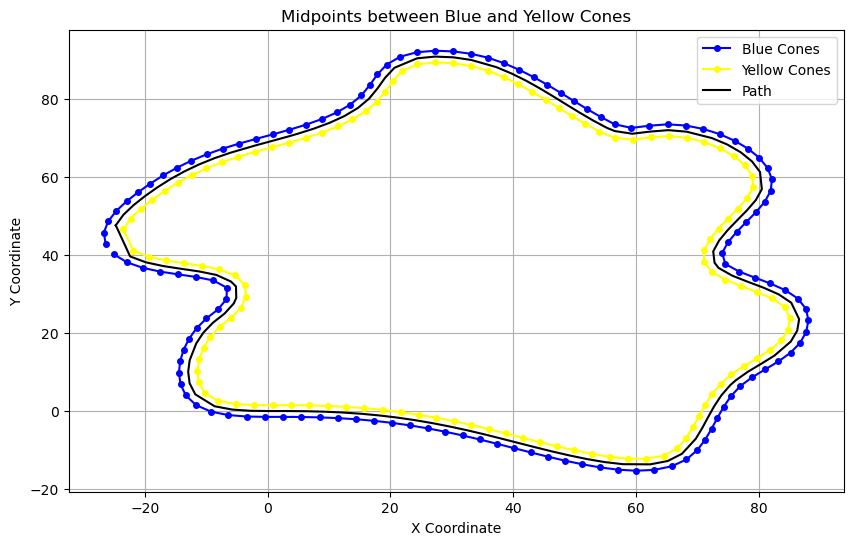

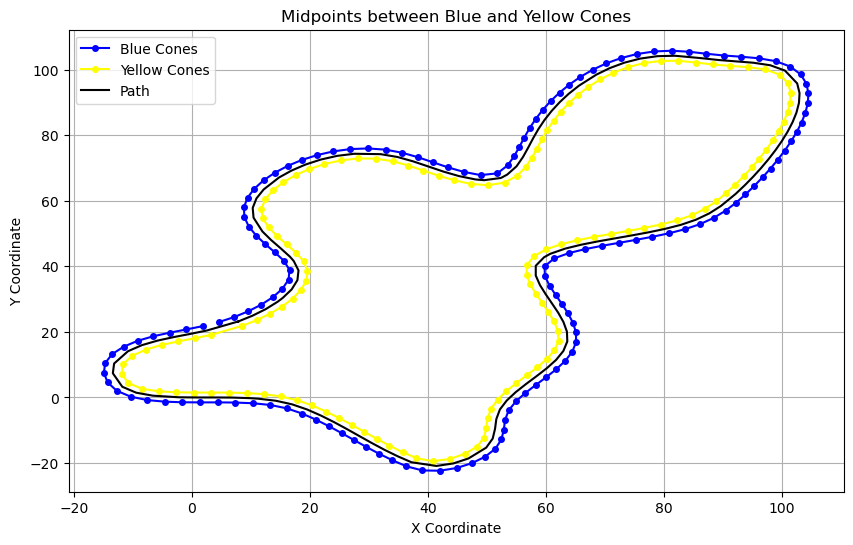

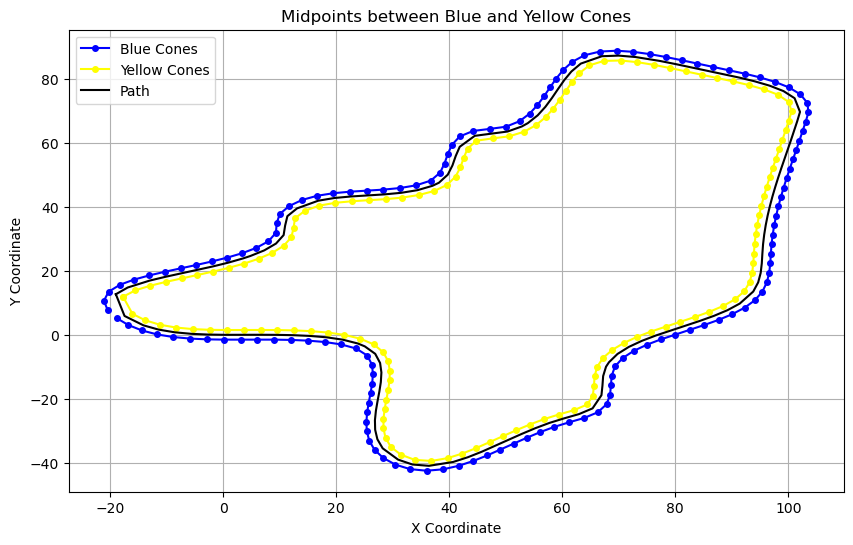

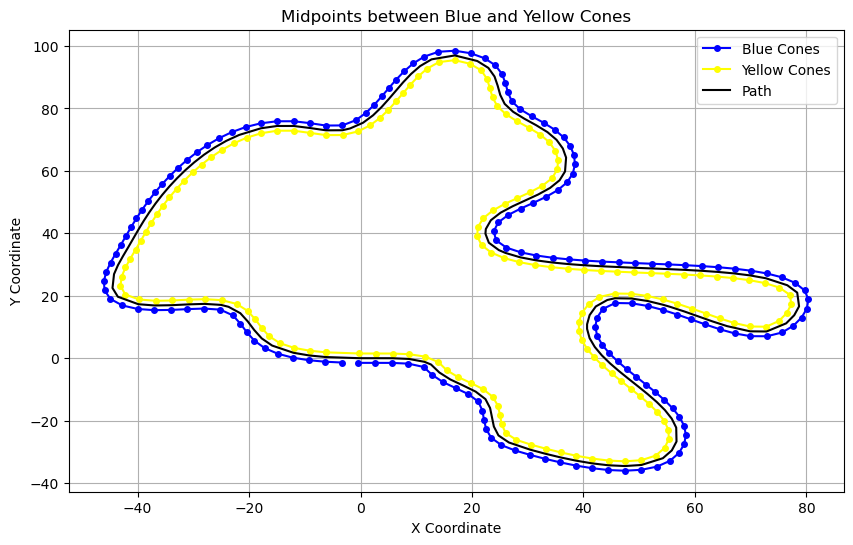

Data loaded successfully!


In [17]:
#src_train,tgt_train = generateSrcTgt(train_dir)
#src_valid,tgt_valid = generateSrcTgt(valid_dir)
src_ccw,tgt_ccw = generateSrcTgt(ccw_dir)

In [18]:
#src_train.shape, tgt_train.shape

In [19]:
#src_valid.shape, tgt_valid.shape

In [20]:
# save the data
#torch.save(src_train, '../inputs/tensors/train/src_train.pt')
#torch.save(tgt_train, '../inputs/tensors/train/tgt_train.pt')
#torch.save(src_valid, '../inputs/tensors/valid/src_valid.pt')
#torch.save(tgt_valid, '../inputs/tensors/valid/tgt_valid.pt')
torch.save(src_ccw, '../inputs/tensors/ccw/src_ccw.pt')
torch.save(tgt_ccw, '../inputs/tensors/ccw/tgt_ccw.pt')